<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[16:11:01] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


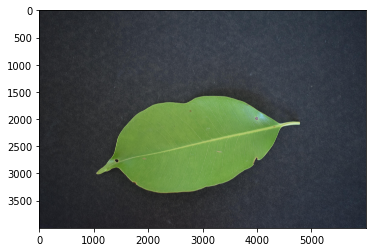

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

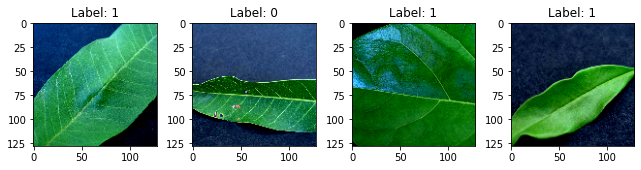

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[16:11:09] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[16:11:11] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2568326143302544 samples/sec                   batch loss = 0.7790911793708801 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2556618754244082 samples/sec                   batch loss = 0.6779959201812744 | accuracy = 0.6


Epoch[1] Batch[15] Speed: 1.258096949830946 samples/sec                   batch loss = 0.8257970213890076 | accuracy = 0.6166666666666667


Epoch[1] Batch[20] Speed: 1.2589512366595996 samples/sec                   batch loss = 1.2655519247055054 | accuracy = 0.5625


Epoch[1] Batch[25] Speed: 1.2650266446152572 samples/sec                   batch loss = 0.40364277362823486 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.2600375490410936 samples/sec                   batch loss = 0.8551719188690186 | accuracy = 0.55


Epoch[1] Batch[35] Speed: 1.265311623378362 samples/sec                   batch loss = 0.6720166802406311 | accuracy = 0.5642857142857143


Epoch[1] Batch[40] Speed: 1.2640079921464804 samples/sec                   batch loss = 0.4600139856338501 | accuracy = 0.58125


Epoch[1] Batch[45] Speed: 1.258772428699492 samples/sec                   batch loss = 1.9842487573623657 | accuracy = 0.6


Epoch[1] Batch[50] Speed: 1.2569702813555805 samples/sec                   batch loss = 0.42745673656463623 | accuracy = 0.61


Epoch[1] Batch[55] Speed: 1.2563098109816104 samples/sec                   batch loss = 0.7211621999740601 | accuracy = 0.6181818181818182


Epoch[1] Batch[60] Speed: 1.2603189586805952 samples/sec                   batch loss = 1.4651992321014404 | accuracy = 0.6125


Epoch[1] Batch[65] Speed: 1.2637618671526705 samples/sec                   batch loss = 0.7712306976318359 | accuracy = 0.6153846153846154


Epoch[1] Batch[70] Speed: 1.2678232019616282 samples/sec                   batch loss = 1.1247127056121826 | accuracy = 0.6214285714285714


Epoch[1] Batch[75] Speed: 1.2680756079874507 samples/sec                   batch loss = 1.3902685642242432 | accuracy = 0.61


Epoch[1] Batch[80] Speed: 1.2703765140944707 samples/sec                   batch loss = 0.13813042640686035 | accuracy = 0.61875


Epoch[1] Batch[85] Speed: 1.2674766667779733 samples/sec                   batch loss = 0.5215634703636169 | accuracy = 0.6205882352941177


Epoch[1] Batch[90] Speed: 1.2665750122167767 samples/sec                   batch loss = 0.3390878438949585 | accuracy = 0.6194444444444445


Epoch[1] Batch[95] Speed: 1.264001040299318 samples/sec                   batch loss = 0.25634193420410156 | accuracy = 0.6289473684210526


Epoch[1] Batch[100] Speed: 1.2641495217135248 samples/sec                   batch loss = 1.2777724266052246 | accuracy = 0.6225


Epoch[1] Batch[105] Speed: 1.261668212679764 samples/sec                   batch loss = 0.6396591663360596 | accuracy = 0.6285714285714286


Epoch[1] Batch[110] Speed: 1.2604986798255113 samples/sec                   batch loss = 0.7282301783561707 | accuracy = 0.634090909090909


Epoch[1] Batch[115] Speed: 1.2538068657092758 samples/sec                   batch loss = 1.1013524532318115 | accuracy = 0.6217391304347826


Epoch[1] Batch[120] Speed: 1.2701522308232913 samples/sec                   batch loss = 0.5876429080963135 | accuracy = 0.6208333333333333


Epoch[1] Batch[125] Speed: 1.2673320936899655 samples/sec                   batch loss = 0.54461669921875 | accuracy = 0.626


Epoch[1] Batch[130] Speed: 1.269479087460815 samples/sec                   batch loss = 0.6761060357093811 | accuracy = 0.6269230769230769


Epoch[1] Batch[135] Speed: 1.2643307181911916 samples/sec                   batch loss = 0.4015248715877533 | accuracy = 0.6277777777777778


Epoch[1] Batch[140] Speed: 1.2627913463815326 samples/sec                   batch loss = 0.3725168704986572 | accuracy = 0.6339285714285714


Epoch[1] Batch[145] Speed: 1.2604836221882532 samples/sec                   batch loss = 0.657134473323822 | accuracy = 0.6396551724137931


Epoch[1] Batch[150] Speed: 1.2679750743358482 samples/sec                   batch loss = 0.4633941352367401 | accuracy = 0.6433333333333333


Epoch[1] Batch[155] Speed: 1.264913814389463 samples/sec                   batch loss = 0.6987390518188477 | accuracy = 0.6419354838709678


Epoch[1] Batch[160] Speed: 1.268360907498769 samples/sec                   batch loss = 0.31680312752723694 | accuracy = 0.64375


Epoch[1] Batch[165] Speed: 1.2679997989607177 samples/sec                   batch loss = 0.2389228641986847 | accuracy = 0.6439393939393939


Epoch[1] Batch[170] Speed: 1.2675432197812468 samples/sec                   batch loss = 1.412296175956726 | accuracy = 0.6338235294117647


Epoch[1] Batch[175] Speed: 1.2647760228632254 samples/sec                   batch loss = 0.3119167387485504 | accuracy = 0.6314285714285715


Epoch[1] Batch[180] Speed: 1.2654891440653004 samples/sec                   batch loss = 1.204380750656128 | accuracy = 0.6305555555555555


Epoch[1] Batch[185] Speed: 1.2668269214433199 samples/sec                   batch loss = 0.8193374276161194 | accuracy = 0.6337837837837837


Epoch[1] Batch[190] Speed: 1.2689687471778157 samples/sec                   batch loss = 0.3551071882247925 | accuracy = 0.6381578947368421


Epoch[1] Batch[195] Speed: 1.2675093199681333 samples/sec                   batch loss = 0.2273833453655243 | accuracy = 0.6435897435897436


Epoch[1] Batch[200] Speed: 1.2668097034999726 samples/sec                   batch loss = 1.0157636404037476 | accuracy = 0.6425


Epoch[1] Batch[205] Speed: 1.2612370398229886 samples/sec                   batch loss = 0.8559532761573792 | accuracy = 0.6390243902439025


Epoch[1] Batch[210] Speed: 1.261584819488238 samples/sec                   batch loss = 0.8976415395736694 | accuracy = 0.6404761904761904


Epoch[1] Batch[215] Speed: 1.2638775387211474 samples/sec                   batch loss = 0.38787099719047546 | accuracy = 0.6430232558139535


Epoch[1] Batch[220] Speed: 1.2642537366856437 samples/sec                   batch loss = 0.3875258266925812 | accuracy = 0.6454545454545455


Epoch[1] Batch[225] Speed: 1.2606744735754325 samples/sec                   batch loss = 0.6932808756828308 | accuracy = 0.6466666666666666


Epoch[1] Batch[230] Speed: 1.2621595929363907 samples/sec                   batch loss = 0.6182494163513184 | accuracy = 0.6456521739130435


Epoch[1] Batch[235] Speed: 1.2614890115698791 samples/sec                   batch loss = 0.3600884675979614 | accuracy = 0.648936170212766


Epoch[1] Batch[240] Speed: 1.2597689404613848 samples/sec                   batch loss = 0.4958373010158539 | accuracy = 0.646875


Epoch[1] Batch[245] Speed: 1.267103620582839 samples/sec                   batch loss = 0.6589654684066772 | accuracy = 0.6438775510204081


Epoch[1] Batch[250] Speed: 1.2581733720637063 samples/sec                   batch loss = 0.5551565885543823 | accuracy = 0.648


Epoch[1] Batch[255] Speed: 1.2614107634237541 samples/sec                   batch loss = 0.8075658082962036 | accuracy = 0.6519607843137255


Epoch[1] Batch[260] Speed: 1.264204961177645 samples/sec                   batch loss = 0.6030412912368774 | accuracy = 0.6509615384615385


Epoch[1] Batch[265] Speed: 1.267877718520563 samples/sec                   batch loss = 0.46149754524230957 | accuracy = 0.6528301886792452


Epoch[1] Batch[270] Speed: 1.2616425958505526 samples/sec                   batch loss = 0.44989871978759766 | accuracy = 0.6537037037037037


Epoch[1] Batch[275] Speed: 1.267258958016403 samples/sec                   batch loss = 0.7416760921478271 | accuracy = 0.6527272727272727


Epoch[1] Batch[280] Speed: 1.2568264002511673 samples/sec                   batch loss = 0.5133645534515381 | accuracy = 0.6508928571428572


Epoch[1] Batch[285] Speed: 1.2660397748852243 samples/sec                   batch loss = 0.7039086818695068 | accuracy = 0.6491228070175439


Epoch[1] Batch[290] Speed: 1.2683410589230089 samples/sec                   batch loss = 0.4293758273124695 | accuracy = 0.6508620689655172


Epoch[1] Batch[295] Speed: 1.2659968799090988 samples/sec                   batch loss = 0.3461226224899292 | accuracy = 0.6491525423728813


Epoch[1] Batch[300] Speed: 1.2601121250262692 samples/sec                   batch loss = 0.525485098361969 | accuracy = 0.6516666666666666


Epoch[1] Batch[305] Speed: 1.2676293181349731 samples/sec                   batch loss = 0.7594743371009827 | accuracy = 0.6516393442622951


Epoch[1] Batch[310] Speed: 1.2637962332020163 samples/sec                   batch loss = 0.42860284447669983 | accuracy = 0.6540322580645161


Epoch[1] Batch[315] Speed: 1.2702587843544473 samples/sec                   batch loss = 0.5024619698524475 | accuracy = 0.6531746031746032


Epoch[1] Batch[320] Speed: 1.2637836670059914 samples/sec                   batch loss = 0.20604409277439117 | accuracy = 0.65546875


Epoch[1] Batch[325] Speed: 1.2631202983687084 samples/sec                   batch loss = 0.5819341540336609 | accuracy = 0.6576923076923077


Epoch[1] Batch[330] Speed: 1.2613056890642214 samples/sec                   batch loss = 0.5274618864059448 | accuracy = 0.6583333333333333


Epoch[1] Batch[335] Speed: 1.2614644453488864 samples/sec                   batch loss = 0.2637099027633667 | accuracy = 0.6604477611940298


Epoch[1] Batch[340] Speed: 1.2643521565416174 samples/sec                   batch loss = 0.38235020637512207 | accuracy = 0.6610294117647059


Epoch[1] Batch[345] Speed: 1.261122514629532 samples/sec                   batch loss = 0.4565705358982086 | accuracy = 0.6623188405797101


Epoch[1] Batch[350] Speed: 1.261114267343161 samples/sec                   batch loss = 0.6893516182899475 | accuracy = 0.6642857142857143


Epoch[1] Batch[355] Speed: 1.2620692041626609 samples/sec                   batch loss = 0.9416873455047607 | accuracy = 0.6654929577464789


Epoch[1] Batch[360] Speed: 1.2639992309269816 samples/sec                   batch loss = 0.5251484513282776 | accuracy = 0.6666666666666666


Epoch[1] Batch[365] Speed: 1.2634872914862372 samples/sec                   batch loss = 0.448672890663147 | accuracy = 0.6678082191780822


Epoch[1] Batch[370] Speed: 1.2629834677539864 samples/sec                   batch loss = 0.47337451577186584 | accuracy = 0.6662162162162162


Epoch[1] Batch[375] Speed: 1.2620145214426122 samples/sec                   batch loss = 0.5482411980628967 | accuracy = 0.6666666666666666


Epoch[1] Batch[380] Speed: 1.2640367526555205 samples/sec                   batch loss = 0.28145724534988403 | accuracy = 0.6671052631578948


Epoch[1] Batch[385] Speed: 1.2666864175697268 samples/sec                   batch loss = 0.5689257383346558 | accuracy = 0.6662337662337663


Epoch[1] Batch[390] Speed: 1.2627499067833567 samples/sec                   batch loss = 0.6810205578804016 | accuracy = 0.6647435897435897


Epoch[1] Batch[395] Speed: 1.2594106271359298 samples/sec                   batch loss = 0.6121337413787842 | accuracy = 0.6626582278481012


Epoch[1] Batch[400] Speed: 1.258362391852319 samples/sec                   batch loss = 0.24134202301502228 | accuracy = 0.664375


Epoch[1] Batch[405] Speed: 1.2625435096677364 samples/sec                   batch loss = 1.4537845849990845 | accuracy = 0.662962962962963


Epoch[1] Batch[410] Speed: 1.2623622551547613 samples/sec                   batch loss = 0.6000605821609497 | accuracy = 0.6628048780487805


Epoch[1] Batch[415] Speed: 1.2567474114797383 samples/sec                   batch loss = 1.0599586963653564 | accuracy = 0.6608433734939759


Epoch[1] Batch[420] Speed: 1.2632601073060776 samples/sec                   batch loss = 0.5175867676734924 | accuracy = 0.6636904761904762


Epoch[1] Batch[425] Speed: 1.2651683069955433 samples/sec                   batch loss = 0.7555676698684692 | accuracy = 0.6617647058823529


Epoch[1] Batch[430] Speed: 1.2692847929126143 samples/sec                   batch loss = 0.6353235244750977 | accuracy = 0.6593023255813953


Epoch[1] Batch[435] Speed: 1.2694282750858104 samples/sec                   batch loss = 0.4849013388156891 | accuracy = 0.6614942528735632


Epoch[1] Batch[440] Speed: 1.2661941826458385 samples/sec                   batch loss = 0.5320651531219482 | accuracy = 0.6625


Epoch[1] Batch[445] Speed: 1.2738061912546363 samples/sec                   batch loss = 0.7281234264373779 | accuracy = 0.6612359550561798


Epoch[1] Batch[450] Speed: 1.2731761248818152 samples/sec                   batch loss = 0.3315003514289856 | accuracy = 0.6605555555555556


Epoch[1] Batch[455] Speed: 1.2695832223146526 samples/sec                   batch loss = 0.674354076385498 | accuracy = 0.6598901098901099


Epoch[1] Batch[460] Speed: 1.2705669092504137 samples/sec                   batch loss = 0.3066806197166443 | accuracy = 0.6608695652173913


Epoch[1] Batch[465] Speed: 1.2691539201312514 samples/sec                   batch loss = 0.44045400619506836 | accuracy = 0.6618279569892473


Epoch[1] Batch[470] Speed: 1.2722286236001172 samples/sec                   batch loss = 1.27154541015625 | accuracy = 0.6606382978723404


Epoch[1] Batch[475] Speed: 1.2676318083615021 samples/sec                   batch loss = 0.34259703755378723 | accuracy = 0.6610526315789473


Epoch[1] Batch[480] Speed: 1.2651239446564981 samples/sec                   batch loss = 0.7658290863037109 | accuracy = 0.6614583333333334


Epoch[1] Batch[485] Speed: 1.2733463881850884 samples/sec                   batch loss = 0.6405938863754272 | accuracy = 0.6618556701030928


Epoch[1] Batch[490] Speed: 1.2683166086329392 samples/sec                   batch loss = 0.1813802868127823 | accuracy = 0.6622448979591836


Epoch[1] Batch[495] Speed: 1.2693886077603385 samples/sec                   batch loss = 0.30847010016441345 | accuracy = 0.6631313131313131


Epoch[1] Batch[500] Speed: 1.2658919953074244 samples/sec                   batch loss = 0.6511965394020081 | accuracy = 0.6635


Epoch[1] Batch[505] Speed: 1.2611783525435603 samples/sec                   batch loss = 0.5472429394721985 | accuracy = 0.6653465346534654


Epoch[1] Batch[510] Speed: 1.2620374002680206 samples/sec                   batch loss = 0.3583891689777374 | accuracy = 0.6656862745098039


Epoch[1] Batch[515] Speed: 1.2589757995654087 samples/sec                   batch loss = 0.5379400253295898 | accuracy = 0.666504854368932


Epoch[1] Batch[520] Speed: 1.2650174877349096 samples/sec                   batch loss = 1.0078965425491333 | accuracy = 0.6649038461538461


Epoch[1] Batch[525] Speed: 1.2638427874241087 samples/sec                   batch loss = 0.7183032035827637 | accuracy = 0.6642857142857143


Epoch[1] Batch[530] Speed: 1.2673609099318133 samples/sec                   batch loss = 0.46115610003471375 | accuracy = 0.6641509433962264


Epoch[1] Batch[535] Speed: 1.2656932589593777 samples/sec                   batch loss = 0.48885539174079895 | accuracy = 0.6654205607476635


Epoch[1] Batch[540] Speed: 1.2648759544876695 samples/sec                   batch loss = 0.4155913293361664 | accuracy = 0.6662037037037037


Epoch[1] Batch[545] Speed: 1.26436035094761 samples/sec                   batch loss = 0.37577176094055176 | accuracy = 0.6688073394495413


Epoch[1] Batch[550] Speed: 1.265054974553321 samples/sec                   batch loss = 0.6486669778823853 | accuracy = 0.6686363636363636


Epoch[1] Batch[555] Speed: 1.2642488780189987 samples/sec                   batch loss = 0.4905763864517212 | accuracy = 0.6698198198198199


Epoch[1] Batch[560] Speed: 1.2667825383633398 samples/sec                   batch loss = 0.7930051684379578 | accuracy = 0.6709821428571429


Epoch[1] Batch[565] Speed: 1.2647205333030997 samples/sec                   batch loss = 0.8301396369934082 | accuracy = 0.6712389380530973


Epoch[1] Batch[570] Speed: 1.2687180962380273 samples/sec                   batch loss = 0.6623684763908386 | accuracy = 0.6714912280701755


Epoch[1] Batch[575] Speed: 1.2645453250413232 samples/sec                   batch loss = 0.22966624796390533 | accuracy = 0.6730434782608695


Epoch[1] Batch[580] Speed: 1.2715589641213836 samples/sec                   batch loss = 0.7711887955665588 | accuracy = 0.6737068965517241


Epoch[1] Batch[585] Speed: 1.2701116528613103 samples/sec                   batch loss = 0.6952520608901978 | accuracy = 0.6756410256410257


Epoch[1] Batch[590] Speed: 1.2701334800209978 samples/sec                   batch loss = 0.5880340337753296 | accuracy = 0.6754237288135593


Epoch[1] Batch[595] Speed: 1.2654340691467054 samples/sec                   batch loss = 0.6162124276161194 | accuracy = 0.6760504201680673


Epoch[1] Batch[600] Speed: 1.263115828797571 samples/sec                   batch loss = 1.1385527849197388 | accuracy = 0.67625


Epoch[1] Batch[605] Speed: 1.2667832079125627 samples/sec                   batch loss = 0.2768998444080353 | accuracy = 0.678099173553719


Epoch[1] Batch[610] Speed: 1.2652665830406384 samples/sec                   batch loss = 0.5345712304115295 | accuracy = 0.6770491803278689


Epoch[1] Batch[615] Speed: 1.2666549543298136 samples/sec                   batch loss = 0.7807406187057495 | accuracy = 0.6760162601626016


Epoch[1] Batch[620] Speed: 1.2679451760775071 samples/sec                   batch loss = 0.6256148219108582 | accuracy = 0.6774193548387096


Epoch[1] Batch[625] Speed: 1.2719435102717385 samples/sec                   batch loss = 0.5704690217971802 | accuracy = 0.6784


Epoch[1] Batch[630] Speed: 1.2679436428714967 samples/sec                   batch loss = 0.3623795211315155 | accuracy = 0.6785714285714286


Epoch[1] Batch[635] Speed: 1.2696061842351405 samples/sec                   batch loss = 0.2544025778770447 | accuracy = 0.6783464566929134


Epoch[1] Batch[640] Speed: 1.2710785360654895 samples/sec                   batch loss = 0.4104909896850586 | accuracy = 0.68046875


Epoch[1] Batch[645] Speed: 1.2679324314152383 samples/sec                   batch loss = 0.6027073264122009 | accuracy = 0.6806201550387597


Epoch[1] Batch[650] Speed: 1.2645115853908546 samples/sec                   batch loss = 0.875813364982605 | accuracy = 0.6796153846153846


Epoch[1] Batch[655] Speed: 1.2569114254826763 samples/sec                   batch loss = 0.43963247537612915 | accuracy = 0.6797709923664123


Epoch[1] Batch[660] Speed: 1.2670300328394972 samples/sec                   batch loss = 0.46215948462486267 | accuracy = 0.6799242424242424


Epoch[1] Batch[665] Speed: 1.2688220103184902 samples/sec                   batch loss = 0.3148958683013916 | accuracy = 0.6800751879699248


Epoch[1] Batch[670] Speed: 1.2650343708361644 samples/sec                   batch loss = 0.5222364068031311 | accuracy = 0.6805970149253732


Epoch[1] Batch[675] Speed: 1.2597285502758648 samples/sec                   batch loss = 0.6430901288986206 | accuracy = 0.6811111111111111


Epoch[1] Batch[680] Speed: 1.2541703411558058 samples/sec                   batch loss = 0.5814515352249146 | accuracy = 0.6816176470588236


Epoch[1] Batch[685] Speed: 1.2559651211964162 samples/sec                   batch loss = 0.36861559748649597 | accuracy = 0.6828467153284672


Epoch[1] Batch[690] Speed: 1.2625847456861805 samples/sec                   batch loss = 0.547514796257019 | accuracy = 0.6829710144927537


Epoch[1] Batch[695] Speed: 1.2577922023885075 samples/sec                   batch loss = 0.7786581516265869 | accuracy = 0.6838129496402877


Epoch[1] Batch[700] Speed: 1.265970513838418 samples/sec                   batch loss = 0.49593231081962585 | accuracy = 0.6857142857142857


Epoch[1] Batch[705] Speed: 1.259504984954 samples/sec                   batch loss = 0.5306214690208435 | accuracy = 0.6865248226950355


Epoch[1] Batch[710] Speed: 1.2663059989011953 samples/sec                   batch loss = 0.40838661789894104 | accuracy = 0.6869718309859155


Epoch[1] Batch[715] Speed: 1.26029519539019 samples/sec                   batch loss = 0.16869725286960602 | accuracy = 0.6884615384615385


Epoch[1] Batch[720] Speed: 1.2669134008593939 samples/sec                   batch loss = 0.4833325743675232 | accuracy = 0.6888888888888889


Epoch[1] Batch[725] Speed: 1.2589091985255563 samples/sec                   batch loss = 0.381210058927536 | accuracy = 0.6896551724137931


Epoch[1] Batch[730] Speed: 1.260382394960158 samples/sec                   batch loss = 0.3154502809047699 | accuracy = 0.690068493150685


Epoch[1] Batch[735] Speed: 1.261153608817092 samples/sec                   batch loss = 0.16457012295722961 | accuracy = 0.6908163265306122


Epoch[1] Batch[740] Speed: 1.2611693460939546 samples/sec                   batch loss = 0.5404855012893677 | accuracy = 0.6908783783783784


Epoch[1] Batch[745] Speed: 1.2546595565470855 samples/sec                   batch loss = 0.3382627069950104 | accuracy = 0.6912751677852349


Epoch[1] Batch[750] Speed: 1.2595291912420719 samples/sec                   batch loss = 0.8636937737464905 | accuracy = 0.691


Epoch[1] Batch[755] Speed: 1.258129498906153 samples/sec                   batch loss = 0.7861761450767517 | accuracy = 0.6907284768211921


Epoch[1] Batch[760] Speed: 1.2594868308485245 samples/sec                   batch loss = 0.3042512536048889 | accuracy = 0.6917763157894737


Epoch[1] Batch[765] Speed: 1.258984396808883 samples/sec                   batch loss = 1.0528080463409424 | accuracy = 0.6905228758169935


Epoch[1] Batch[770] Speed: 1.2647293998647162 samples/sec                   batch loss = 0.7167669534683228 | accuracy = 0.6902597402597402


Epoch[1] Batch[775] Speed: 1.259638603923652 samples/sec                   batch loss = 0.6791673898696899 | accuracy = 0.6906451612903226


Epoch[1] Batch[780] Speed: 1.2634979486967846 samples/sec                   batch loss = 0.6284524202346802 | accuracy = 0.6919871794871795


Epoch[1] Batch[785] Speed: 1.2626265545376605 samples/sec                   batch loss = 0.5094839930534363 | accuracy = 0.6917197452229299


[Epoch 1] training: accuracy=0.6919416243654822
[Epoch 1] time cost: 650.7442674636841
[Epoch 1] validation: validation accuracy=0.7488888888888889


Epoch[2] Batch[5] Speed: 1.256918770394606 samples/sec                   batch loss = 0.2793383002281189 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2573359704298652 samples/sec                   batch loss = 0.42043790221214294 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.25620502032275 samples/sec                   batch loss = 1.2575076818466187 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2532627963453633 samples/sec                   batch loss = 0.5766860842704773 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.260721745453059 samples/sec                   batch loss = 0.4608754515647888 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.260864245666131 samples/sec                   batch loss = 0.22682400047779083 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.2615195546924134 samples/sec                   batch loss = 0.6168692708015442 | accuracy = 0.7571428571428571


Epoch[2] Batch[40] Speed: 1.258632289350414 samples/sec                   batch loss = 0.8515613079071045 | accuracy = 0.725


Epoch[2] Batch[45] Speed: 1.2590946597797719 samples/sec                   batch loss = 0.6049599647521973 | accuracy = 0.7388888888888889


Epoch[2] Batch[50] Speed: 1.2595540603897983 samples/sec                   batch loss = 0.5545234680175781 | accuracy = 0.72


Epoch[2] Batch[55] Speed: 1.2644972894718634 samples/sec                   batch loss = 0.4360613524913788 | accuracy = 0.7045454545454546


Epoch[2] Batch[60] Speed: 1.264780122800525 samples/sec                   batch loss = 0.5027939677238464 | accuracy = 0.7083333333333334


Epoch[2] Batch[65] Speed: 1.2653795716499796 samples/sec                   batch loss = 0.4662608504295349 | accuracy = 0.7153846153846154


Epoch[2] Batch[70] Speed: 1.2680002781296387 samples/sec                   batch loss = 0.7166080474853516 | accuracy = 0.7214285714285714


Epoch[2] Batch[75] Speed: 1.2620554381010662 samples/sec                   batch loss = 0.8885877132415771 | accuracy = 0.7166666666666667


Epoch[2] Batch[80] Speed: 1.2639215280348606 samples/sec                   batch loss = 0.3454461395740509 | accuracy = 0.7125


Epoch[2] Batch[85] Speed: 1.2695714054156886 samples/sec                   batch loss = 0.36718037724494934 | accuracy = 0.7205882352941176


Epoch[2] Batch[90] Speed: 1.267541112960356 samples/sec                   batch loss = 0.34082525968551636 | accuracy = 0.7277777777777777


Epoch[2] Batch[95] Speed: 1.2614019433324521 samples/sec                   batch loss = 0.31750988960266113 | accuracy = 0.7315789473684211


Epoch[2] Batch[100] Speed: 1.2669975957034556 samples/sec                   batch loss = 0.3620932698249817 | accuracy = 0.7325


Epoch[2] Batch[105] Speed: 1.2745457044138886 samples/sec                   batch loss = 0.24656301736831665 | accuracy = 0.7261904761904762


Epoch[2] Batch[110] Speed: 1.26262018801111 samples/sec                   batch loss = 0.6030122637748718 | accuracy = 0.7272727272727273


Epoch[2] Batch[115] Speed: 1.267623284165113 samples/sec                   batch loss = 0.3196742534637451 | accuracy = 0.7282608695652174


Epoch[2] Batch[120] Speed: 1.2703570833364568 samples/sec                   batch loss = 0.25265344977378845 | accuracy = 0.7291666666666666


Epoch[2] Batch[125] Speed: 1.2630780764480265 samples/sec                   batch loss = 0.3319597542285919 | accuracy = 0.734


Epoch[2] Batch[130] Speed: 1.2591960582874855 samples/sec                   batch loss = 0.7567297220230103 | accuracy = 0.7365384615384616


Epoch[2] Batch[135] Speed: 1.2579231945694287 samples/sec                   batch loss = 0.08200818300247192 | accuracy = 0.7407407407407407


Epoch[2] Batch[140] Speed: 1.2638233656138858 samples/sec                   batch loss = 0.7127885222434998 | accuracy = 0.7410714285714286


Epoch[2] Batch[145] Speed: 1.260337326140556 samples/sec                   batch loss = 0.5912111401557922 | accuracy = 0.7379310344827587


Epoch[2] Batch[150] Speed: 1.2623178044485202 samples/sec                   batch loss = 0.2511674761772156 | accuracy = 0.7433333333333333


Epoch[2] Batch[155] Speed: 1.2657140751221092 samples/sec                   batch loss = 0.4996640086174011 | accuracy = 0.7419354838709677


Epoch[2] Batch[160] Speed: 1.2645382719711922 samples/sec                   batch loss = 0.43426984548568726 | accuracy = 0.740625


Epoch[2] Batch[165] Speed: 1.2601629515359902 samples/sec                   batch loss = 0.5587790012359619 | accuracy = 0.740909090909091


Epoch[2] Batch[170] Speed: 1.2661776508069336 samples/sec                   batch loss = 0.21305198967456818 | accuracy = 0.7441176470588236


Epoch[2] Batch[175] Speed: 1.2657283030768036 samples/sec                   batch loss = 0.9165465831756592 | accuracy = 0.7442857142857143


Epoch[2] Batch[180] Speed: 1.2655068034163794 samples/sec                   batch loss = 0.5146234631538391 | accuracy = 0.7430555555555556


Epoch[2] Batch[185] Speed: 1.258970981381397 samples/sec                   batch loss = 0.5584379434585571 | accuracy = 0.7405405405405405


Epoch[2] Batch[190] Speed: 1.2631649958198714 samples/sec                   batch loss = 0.9442210793495178 | accuracy = 0.7460526315789474


Epoch[2] Batch[195] Speed: 1.2586672268340167 samples/sec                   batch loss = 0.8762496709823608 | accuracy = 0.7474358974358974


Epoch[2] Batch[200] Speed: 1.2591447427424867 samples/sec                   batch loss = 0.2260907143354416 | accuracy = 0.74875


Epoch[2] Batch[205] Speed: 1.2667840687626033 samples/sec                   batch loss = 1.038823127746582 | accuracy = 0.7475609756097561


Epoch[2] Batch[210] Speed: 1.2588429823502387 samples/sec                   batch loss = 0.4986400604248047 | accuracy = 0.75


Epoch[2] Batch[215] Speed: 1.2590185035140176 samples/sec                   batch loss = 0.5160235166549683 | accuracy = 0.75


Epoch[2] Batch[220] Speed: 1.2749479487182216 samples/sec                   batch loss = 0.6477387547492981 | accuracy = 0.75


Epoch[2] Batch[225] Speed: 1.26506737526217 samples/sec                   batch loss = 0.2691369354724884 | accuracy = 0.75


Epoch[2] Batch[230] Speed: 1.2652533196540625 samples/sec                   batch loss = 0.2276294082403183 | accuracy = 0.7467391304347826


Epoch[2] Batch[235] Speed: 1.2628634919875026 samples/sec                   batch loss = 0.6291271448135376 | accuracy = 0.7489361702127659


Epoch[2] Batch[240] Speed: 1.2698432497577776 samples/sec                   batch loss = 1.3904709815979004 | accuracy = 0.746875


Epoch[2] Batch[245] Speed: 1.2616169800615649 samples/sec                   batch loss = 0.7475360035896301 | accuracy = 0.746938775510204


Epoch[2] Batch[250] Speed: 1.269700922948756 samples/sec                   batch loss = 0.4494592249393463 | accuracy = 0.747


Epoch[2] Batch[255] Speed: 1.2657313587866517 samples/sec                   batch loss = 0.46689677238464355 | accuracy = 0.7480392156862745


Epoch[2] Batch[260] Speed: 1.2670061114869462 samples/sec                   batch loss = 0.25112831592559814 | accuracy = 0.7480769230769231


Epoch[2] Batch[265] Speed: 1.2608792176381631 samples/sec                   batch loss = 0.5583138465881348 | accuracy = 0.7481132075471698


Epoch[2] Batch[270] Speed: 1.2694084891365849 samples/sec                   batch loss = 0.5915274620056152 | accuracy = 0.7444444444444445


Epoch[2] Batch[275] Speed: 1.260256570121104 samples/sec                   batch loss = 0.35498708486557007 | accuracy = 0.7445454545454545


Epoch[2] Batch[280] Speed: 1.2649589249895121 samples/sec                   batch loss = 0.46077704429626465 | accuracy = 0.7464285714285714


Epoch[2] Batch[285] Speed: 1.2657686014361238 samples/sec                   batch loss = 0.41577816009521484 | accuracy = 0.7456140350877193


Epoch[2] Batch[290] Speed: 1.2621010096602858 samples/sec                   batch loss = 0.5080971717834473 | accuracy = 0.746551724137931


Epoch[2] Batch[295] Speed: 1.259996195351645 samples/sec                   batch loss = 0.17199616134166718 | accuracy = 0.747457627118644


Epoch[2] Batch[300] Speed: 1.257057774911257 samples/sec                   batch loss = 0.870090663433075 | accuracy = 0.7483333333333333


Epoch[2] Batch[305] Speed: 1.264405707952947 samples/sec                   batch loss = 0.6010533571243286 | accuracy = 0.7483606557377049


Epoch[2] Batch[310] Speed: 1.2602148234118264 samples/sec                   batch loss = 0.5705376863479614 | accuracy = 0.7491935483870967


Epoch[2] Batch[315] Speed: 1.2592370759295846 samples/sec                   batch loss = 0.5526201128959656 | accuracy = 0.7484126984126984


Epoch[2] Batch[320] Speed: 1.261675613290762 samples/sec                   batch loss = 0.47101253271102905 | accuracy = 0.7515625


Epoch[2] Batch[325] Speed: 1.256840240784027 samples/sec                   batch loss = 0.17535728216171265 | accuracy = 0.7546153846153846


Epoch[2] Batch[330] Speed: 1.257202368458737 samples/sec                   batch loss = 0.18283145129680634 | accuracy = 0.7537878787878788


Epoch[2] Batch[335] Speed: 1.2634844369067961 samples/sec                   batch loss = 0.32008224725723267 | accuracy = 0.755223880597015


Epoch[2] Batch[340] Speed: 1.2663765393123068 samples/sec                   batch loss = 0.8900518417358398 | accuracy = 0.7558823529411764


Epoch[2] Batch[345] Speed: 1.2601449677584453 samples/sec                   batch loss = 0.19100430607795715 | accuracy = 0.7557971014492754


Epoch[2] Batch[350] Speed: 1.2578910334149949 samples/sec                   batch loss = 0.43840140104293823 | accuracy = 0.7542857142857143


Epoch[2] Batch[355] Speed: 1.2658554139653058 samples/sec                   batch loss = 0.254401296377182 | accuracy = 0.7556338028169014


Epoch[2] Batch[360] Speed: 1.2646050886715923 samples/sec                   batch loss = 0.1897665113210678 | accuracy = 0.75625


Epoch[2] Batch[365] Speed: 1.2623860964600446 samples/sec                   batch loss = 0.5667247772216797 | accuracy = 0.7575342465753425


Epoch[2] Batch[370] Speed: 1.2577005523780895 samples/sec                   batch loss = 0.6295056939125061 | accuracy = 0.7567567567567568


Epoch[2] Batch[375] Speed: 1.2631785007784369 samples/sec                   batch loss = 0.7847428321838379 | accuracy = 0.756


Epoch[2] Batch[380] Speed: 1.2625744839367554 samples/sec                   batch loss = 0.4663359820842743 | accuracy = 0.756578947368421


Epoch[2] Batch[385] Speed: 1.2654446637759758 samples/sec                   batch loss = 0.9282727837562561 | accuracy = 0.7558441558441559


Epoch[2] Batch[390] Speed: 1.2594670699431756 samples/sec                   batch loss = 0.5619853138923645 | accuracy = 0.7564102564102564


Epoch[2] Batch[395] Speed: 1.2572596498887576 samples/sec                   batch loss = 0.6890414357185364 | accuracy = 0.7575949367088608


Epoch[2] Batch[400] Speed: 1.264442110256395 samples/sec                   batch loss = 1.096398115158081 | accuracy = 0.758125


Epoch[2] Batch[405] Speed: 1.2665541677263927 samples/sec                   batch loss = 0.4820728898048401 | accuracy = 0.758641975308642


Epoch[2] Batch[410] Speed: 1.2615626211109339 samples/sec                   batch loss = 0.14679335057735443 | accuracy = 0.7603658536585366


Epoch[2] Batch[415] Speed: 1.2632290993880528 samples/sec                   batch loss = 0.11711131036281586 | accuracy = 0.7614457831325301


Epoch[2] Batch[420] Speed: 1.2624986661798443 samples/sec                   batch loss = 1.025808334350586 | accuracy = 0.7607142857142857


Epoch[2] Batch[425] Speed: 1.2628964782977605 samples/sec                   batch loss = 0.6694073677062988 | accuracy = 0.7611764705882353


Epoch[2] Batch[430] Speed: 1.2594466478408954 samples/sec                   batch loss = 0.714919924736023 | accuracy = 0.7610465116279069


Epoch[2] Batch[435] Speed: 1.2614429151234359 samples/sec                   batch loss = 0.9137263894081116 | accuracy = 0.7614942528735632


Epoch[2] Batch[440] Speed: 1.2679102007378982 samples/sec                   batch loss = 0.41254088282585144 | accuracy = 0.7607954545454545


Epoch[2] Batch[445] Speed: 1.2636405061727558 samples/sec                   batch loss = 0.3305962383747101 | accuracy = 0.7606741573033707


Epoch[2] Batch[450] Speed: 1.2697113969604665 samples/sec                   batch loss = 0.45680302381515503 | accuracy = 0.76


Epoch[2] Batch[455] Speed: 1.2652647700433324 samples/sec                   batch loss = 0.3438815772533417 | accuracy = 0.7615384615384615


Epoch[2] Batch[460] Speed: 1.2630441297887047 samples/sec                   batch loss = 0.49184587597846985 | accuracy = 0.7619565217391304


Epoch[2] Batch[465] Speed: 1.260657611919775 samples/sec                   batch loss = 0.42553088068962097 | accuracy = 0.7612903225806451


Epoch[2] Batch[470] Speed: 1.2631535834039551 samples/sec                   batch loss = 0.4255851209163666 | accuracy = 0.7622340425531915


Epoch[2] Batch[475] Speed: 1.2570973346612722 samples/sec                   batch loss = 0.4370192587375641 | accuracy = 0.7626315789473684


Epoch[2] Batch[480] Speed: 1.2604001961381932 samples/sec                   batch loss = 0.8814469575881958 | accuracy = 0.7614583333333333


Epoch[2] Batch[485] Speed: 1.2660415901042206 samples/sec                   batch loss = 0.5554474592208862 | accuracy = 0.7592783505154639


Epoch[2] Batch[490] Speed: 1.2620802172281624 samples/sec                   batch loss = 0.31230729818344116 | accuracy = 0.7602040816326531


Epoch[2] Batch[495] Speed: 1.2600582742223125 samples/sec                   batch loss = 0.38911154866218567 | accuracy = 0.759090909090909


Epoch[2] Batch[500] Speed: 1.2594913693258305 samples/sec                   batch loss = 0.3106318712234497 | accuracy = 0.758


Epoch[2] Batch[505] Speed: 1.2617648069694667 samples/sec                   batch loss = 0.1661599576473236 | accuracy = 0.7594059405940594


Epoch[2] Batch[510] Speed: 1.2622765858645502 samples/sec                   batch loss = 0.5332337021827698 | accuracy = 0.7588235294117647


Epoch[2] Batch[515] Speed: 1.2639141962699303 samples/sec                   batch loss = 0.2815185487270355 | accuracy = 0.7582524271844661


Epoch[2] Batch[520] Speed: 1.26248593577019 samples/sec                   batch loss = 0.8631431460380554 | accuracy = 0.7572115384615384


Epoch[2] Batch[525] Speed: 1.2642617392768218 samples/sec                   batch loss = 0.4828190207481384 | accuracy = 0.758095238095238


Epoch[2] Batch[530] Speed: 1.2625192823877704 samples/sec                   batch loss = 0.4691070318222046 | accuracy = 0.7580188679245283


Epoch[2] Batch[535] Speed: 1.267903876635909 samples/sec                   batch loss = 0.5047202110290527 | accuracy = 0.7574766355140187


Epoch[2] Batch[540] Speed: 1.263886203040776 samples/sec                   batch loss = 0.614374041557312 | accuracy = 0.7574074074074074


Epoch[2] Batch[545] Speed: 1.2641220895502596 samples/sec                   batch loss = 0.5035128593444824 | accuracy = 0.7573394495412844


Epoch[2] Batch[550] Speed: 1.2636227085223652 samples/sec                   batch loss = 0.24387909471988678 | accuracy = 0.7581818181818182


Epoch[2] Batch[555] Speed: 1.2619304180360533 samples/sec                   batch loss = 0.4199298024177551 | accuracy = 0.7581081081081081


Epoch[2] Batch[560] Speed: 1.269851515495327 samples/sec                   batch loss = 0.5454940795898438 | accuracy = 0.7584821428571429


Epoch[2] Batch[565] Speed: 1.2691788827753605 samples/sec                   batch loss = 0.3881332576274872 | accuracy = 0.7584070796460177


Epoch[2] Batch[570] Speed: 1.266163890530345 samples/sec                   batch loss = 0.468072772026062 | accuracy = 0.7574561403508772


Epoch[2] Batch[575] Speed: 1.2634133620377073 samples/sec                   batch loss = 0.4227795898914337 | accuracy = 0.7573913043478261


Epoch[2] Batch[580] Speed: 1.2690833579678225 samples/sec                   batch loss = 0.47949814796447754 | accuracy = 0.7577586206896552


Epoch[2] Batch[585] Speed: 1.2628404881455075 samples/sec                   batch loss = 0.4224456250667572 | accuracy = 0.7568376068376068


Epoch[2] Batch[590] Speed: 1.2641098978598488 samples/sec                   batch loss = 0.8504542708396912 | accuracy = 0.7555084745762712


Epoch[2] Batch[595] Speed: 1.261460082336335 samples/sec                   batch loss = 0.4951171875 | accuracy = 0.7554621848739496


Epoch[2] Batch[600] Speed: 1.2641254232565493 samples/sec                   batch loss = 0.43700307607650757 | accuracy = 0.755


Epoch[2] Batch[605] Speed: 1.2684428014283917 samples/sec                   batch loss = 0.27358531951904297 | accuracy = 0.7553719008264462


Epoch[2] Batch[610] Speed: 1.2622104897918527 samples/sec                   batch loss = 0.3774305284023285 | accuracy = 0.7553278688524591


Epoch[2] Batch[615] Speed: 1.2634376236442715 samples/sec                   batch loss = 0.395219624042511 | accuracy = 0.7560975609756098


Epoch[2] Batch[620] Speed: 1.2681308172305141 samples/sec                   batch loss = 0.28241080045700073 | accuracy = 0.7568548387096774


Epoch[2] Batch[625] Speed: 1.2706144447849133 samples/sec                   batch loss = 0.6048542261123657 | accuracy = 0.756


Epoch[2] Batch[630] Speed: 1.2718087143056511 samples/sec                   batch loss = 0.6507804989814758 | accuracy = 0.7563492063492063


Epoch[2] Batch[635] Speed: 1.2639327638916302 samples/sec                   batch loss = 0.5243828892707825 | accuracy = 0.7566929133858268


Epoch[2] Batch[640] Speed: 1.2614836050221394 samples/sec                   batch loss = 0.45413708686828613 | accuracy = 0.757421875


Epoch[2] Batch[645] Speed: 1.2607230717692894 samples/sec                   batch loss = 0.8147495985031128 | accuracy = 0.7577519379844961


Epoch[2] Batch[650] Speed: 1.2656353974433996 samples/sec                   batch loss = 0.6499344110488892 | accuracy = 0.7565384615384615


Epoch[2] Batch[655] Speed: 1.2640062779852828 samples/sec                   batch loss = 0.46817076206207275 | accuracy = 0.7564885496183206


Epoch[2] Batch[660] Speed: 1.2654719624670239 samples/sec                   batch loss = 1.0204493999481201 | accuracy = 0.7556818181818182


Epoch[2] Batch[665] Speed: 1.2741973237415973 samples/sec                   batch loss = 0.32748138904571533 | accuracy = 0.7563909774436091


Epoch[2] Batch[670] Speed: 1.2724046165767227 samples/sec                   batch loss = 0.322334349155426 | accuracy = 0.7570895522388059


Epoch[2] Batch[675] Speed: 1.2670545292405866 samples/sec                   batch loss = 0.25770851969718933 | accuracy = 0.7577777777777778


Epoch[2] Batch[680] Speed: 1.2572386398107505 samples/sec                   batch loss = 0.39618197083473206 | accuracy = 0.7588235294117647


Epoch[2] Batch[685] Speed: 1.262867864713418 samples/sec                   batch loss = 1.4887832403182983 | accuracy = 0.7591240875912408


Epoch[2] Batch[690] Speed: 1.2601439266080956 samples/sec                   batch loss = 0.37738487124443054 | accuracy = 0.758695652173913


Epoch[2] Batch[695] Speed: 1.2592845236322412 samples/sec                   batch loss = 0.5082037448883057 | accuracy = 0.7597122302158273


Epoch[2] Batch[700] Speed: 1.263075794262456 samples/sec                   batch loss = 0.7440104484558105 | accuracy = 0.7596428571428572


Epoch[2] Batch[705] Speed: 1.2575633851908208 samples/sec                   batch loss = 0.19423963129520416 | accuracy = 0.7609929078014185


Epoch[2] Batch[710] Speed: 1.269650669314557 samples/sec                   batch loss = 0.3291080892086029 | accuracy = 0.7612676056338028


Epoch[2] Batch[715] Speed: 1.2652786062068822 samples/sec                   batch loss = 0.6575866937637329 | accuracy = 0.7615384615384615


Epoch[2] Batch[720] Speed: 1.2666374541768073 samples/sec                   batch loss = 0.3521895706653595 | accuracy = 0.7618055555555555


Epoch[2] Batch[725] Speed: 1.2656966964436396 samples/sec                   batch loss = 0.44621455669403076 | accuracy = 0.7620689655172413


Epoch[2] Batch[730] Speed: 1.261034549135781 samples/sec                   batch loss = 0.24539269506931305 | accuracy = 0.7626712328767123


Epoch[2] Batch[735] Speed: 1.2622719323225708 samples/sec                   batch loss = 0.6574427485466003 | accuracy = 0.7619047619047619


Epoch[2] Batch[740] Speed: 1.260526807319121 samples/sec                   batch loss = 1.0408767461776733 | accuracy = 0.7597972972972973


Epoch[2] Batch[745] Speed: 1.2548202104453818 samples/sec                   batch loss = 0.9176563024520874 | accuracy = 0.7583892617449665


Epoch[2] Batch[750] Speed: 1.2599075353771354 samples/sec                   batch loss = 0.4093373417854309 | accuracy = 0.7583333333333333


Epoch[2] Batch[755] Speed: 1.2556157339940055 samples/sec                   batch loss = 0.6366968154907227 | accuracy = 0.7572847682119205


Epoch[2] Batch[760] Speed: 1.2586923452504313 samples/sec                   batch loss = 0.2989020347595215 | accuracy = 0.7575657894736842


Epoch[2] Batch[765] Speed: 1.2635580891831422 samples/sec                   batch loss = 0.31920695304870605 | accuracy = 0.7581699346405228


Epoch[2] Batch[770] Speed: 1.2629489557488016 samples/sec                   batch loss = 0.5910656452178955 | accuracy = 0.7581168831168831


Epoch[2] Batch[775] Speed: 1.2629602693939292 samples/sec                   batch loss = 0.6255513429641724 | accuracy = 0.7587096774193548


Epoch[2] Batch[780] Speed: 1.2672344537101687 samples/sec                   batch loss = 0.8124362230300903 | accuracy = 0.7580128205128205


Epoch[2] Batch[785] Speed: 1.2649121931381526 samples/sec                   batch loss = 0.4570010006427765 | accuracy = 0.7576433121019108


[Epoch 2] training: accuracy=0.7579314720812182
[Epoch 2] time cost: 641.7189259529114
[Epoch 2] validation: validation accuracy=0.7655555555555555


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.78

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)